# Make more Part 4: Diving deep into back prop
- Implementing back prop by hand from scratch

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('../data/names.txt', 'r').read().splitlines()

In [6]:
# build vocab of characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [7]:
# building the dataset
def build_dataset(words):
    block_size = 3
    X,Y = [],[]
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [8]:
# train, val and test splits:
import random
random.seed(42)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

### Introducing a gradient checker function
- Checks the gradients collected with our implementation of back prop with the one
- We use Bessel's correction: divide by n-1 instead of n

In [48]:
def gradient_comparator(s:str,dt:torch.Tensor, t:torch.Tensor):
    """_summary_

    Args:
        s (str): Label
        dt (torch.Tensor): Pytorch gradient
        t (torch.Tensor): Our gradient
    """
    exact_match = torch.all(dt==t.grad).item()
    approx_match = torch.allclose(dt, t.grad)
    max_diff = torch.max(torch.abs(dt-t.grad)).item()
    print(f'{s:15s} | exact_match: {str(exact_match):5s} | approx_match: {str(approx_match):5s} | max_diff: {max_diff}')    

### Initialising Network
- We will use some non standard ways to initialise network just to make sure we have gradients for all layers and can verify them.
- Setting biases to random values instead of zeros. Because sometimes initialising with zeros could mask incorrect implementation of back prop

In [79]:
n_embed = 10
n_hidden = 64
vocab_size = 27
block_size = 3
fan_in = n_embed*block_size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
# Layer 1
W1 = torch.randn((fan_in, n_hidden), generator=g) * (5/3)*(fan_in**-0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# batch norm params:
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1,n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [80]:
batch_size =32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

In [ ]:
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logits_max = logits.max(1, keepdim=True).values
norm_logits = logits - logits_max # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logits_max, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.4808, grad_fn=<NegBackward0>)

In [77]:
bndiff.shape,bnmeani.shape, hprebn.shape

(torch.Size([32, 64]), torch.Size([1, 64]), torch.Size([32, 64]))

# Backpropagating through the network

In [ ]:
# Step 1: Calculating gradient of log prob
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[torch.arange(n), Yb] = -1.0/n
## Compare gradients:
gradient_comparator('log_probs',dlogprobs, logprobs)

# Step 2: Calculating gradient of probs:
dprobs = (1/probs) * dlogprobs # chain rule
## Compare gradients:
gradient_comparator('probs',dprobs, probs)

# Step 3: Calculating gradient of Inverse of counts sum:
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True) # sum because counts_sum_inv is broadcasted to counts so we need to sum it's gradients
## Compare gradients:
gradient_comparator('counts_sum_inv',dcounts_sum_inv, counts_sum_inv)

# Step 4: Calculating gradient of counts sum:
dcounts = counts_sum_inv * dprobs

# Step 5: Calculating gradient of counts_sum:
dcounts_sum = (-counts_sum**-2)* dcounts_sum_inv
gradient_comparator('counts_sum', dcounts_sum, counts_sum)

# Step 6: Calculating gradient of counts:
dcounts += torch.ones_like(counts)* dcounts_sum # combine gradients from both branches of dcounts
## Compare gradients:
gradient_comparator('counts', dcounts, counts)

# Step 7: Calculating gradient of norm logits:
dnormlogits = dcounts * norm_logits.exp()
gradient_comparator('norm_logits', dnormlogits, norm_logits)

# Step 8: Calculating gradient for logits:
dlogits = dnormlogits.clone() 

# Step 9: Calculating gradient of logit_max:
dlogits_max = (-dnormlogits).sum(dim=1, keepdim=True)
gradient_comparator('logits_max', dlogits_max, logits_max)

# Step 10: Calculating gradient for logits:
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])*dlogits_max
gradient_comparator('logits', dlogits, logits)

# Step 11: Calculating gradient of h, W2 and b2
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
gradient_comparator('h', dh, h)
gradient_comparator('W2', dW2, W2)
gradient_comparator('b2', db2, b2)

# Step 12: Calculating gradient of hpreact
dhpreact = (1.0 - h**2) * dh
gradient_comparator('hpreact', dhpreact, hpreact)

# Step 13: Calculating gradient of bngain, bnraw, bnbias
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
gradient_comparator('bngain', dbngain, bngain)
gradient_comparator('bnraw', dbnraw, bnraw)
gradient_comparator('bnbias', dbnbias, bnbias)

# Step 14 Calculating gradient of bndiff and bnvar_inv
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
gradient_comparator('bnvar_inv', dbnvar_inv, bnvar_inv)

# Step 15: Calculating gradient of bnvar:
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
gradient_comparator('bnvar', dbnvar, bnvar)

# Step 16: Calculate gradient of bndiff2:
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
gradient_comparator('bndiff2', dbndiff2, bndiff2)

## Second of bndiff:
dbndiff += (2*bndiff) * dbndiff2
gradient_comparator('bndiff', dbndiff, bndiff)

# Step 17: Calculate gradient of hprebn and bnmeani:
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
gradient_comparator('bnmeani', dbnmeani, bnmeani)

## Second part of dhprebn:
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
gradient_comparator('hprebn', dhprebn, hprebn)

# Step 18: Calculate gradient of embcat, W1 and b1:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
gradient_comparator('embcat', dembcat, embcat)
gradient_comparator('W1', dW1, W1)
gradient_comparator('b1', db1, b1)

# Step 19: Calculate gradient of emb:
demb = dembcat.view(emb.shape)
gradient_comparator('emb', demb, emb)

# Step 20: Calculate gradient of C:
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[i,j]
        dC[ix] += demb[i,j]
gradient_comparator('C', dC, C)

log_probs       | exact_match: True  | approx_match: True  | max_diff: 0.0
probs           | exact_match: True  | approx_match: True  | max_diff: 0.0
counts_sum_inv  | exact_match: True  | approx_match: True  | max_diff: 0.0
counts_sum      | exact_match: True  | approx_match: True  | max_diff: 0.0
counts          | exact_match: True  | approx_match: True  | max_diff: 0.0
norm_logits     | exact_match: True  | approx_match: True  | max_diff: 0.0
logits_max      | exact_match: True  | approx_match: True  | max_diff: 0.0
logits          | exact_match: True  | approx_match: True  | max_diff: 0.0
h               | exact_match: True  | approx_match: True  | max_diff: 0.0
W2              | exact_match: True  | approx_match: True  | max_diff: 0.0
b2              | exact_match: True  | approx_match: True  | max_diff: 0.0
hpreact         | exact_match: True  | approx_match: True  | max_diff: 0.0
bngain          | exact_match: True  | approx_match: True  | max_diff: 0.0
bnraw           | exact_m

# Calculating simplified gradients for logits:
- Instead of calculating gradients for each and every step of back prop, we can simplify it by calculating gradient of loss wrt logits
- We can use softmax to calculate this
- The gradients boils down to 2 calculations:
    - When y != true label, Softmax is the gradient
    - When y==True label, Softmax-1 is the  gradient
    - And we need to scale the gradient by n because we calculate avg of softmax as our loss
- The idea is: dlogits represents the amount by which we push probabilities up for correct characters and down for incorrect characters

In [ ]:
# simplified gradients for logits:
dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -=1
dlogits /= n
gradient_comparator('logits', dlogits, logits) 

logits          | exact_match: False | approx_match: True  | max_diff: 4.6566128730773926e-09


## Visualizing dlogits

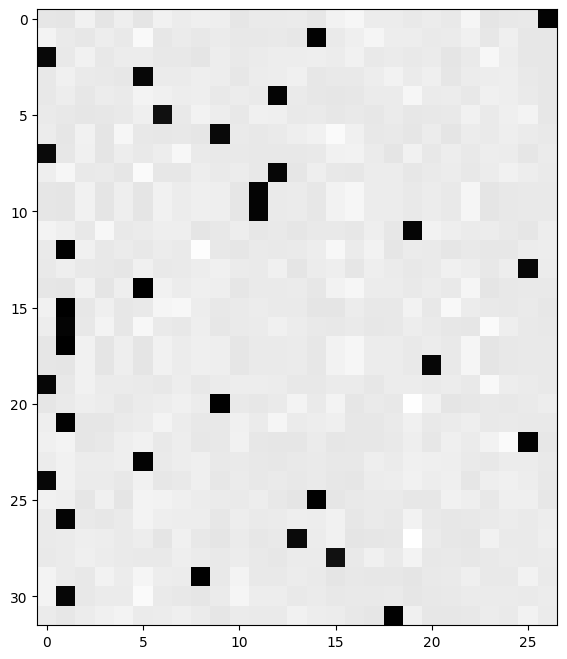

In [88]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [91]:
## MOdifying batch norm to fit in a single step
## Using calculations by hand to calculate gradients 
dhprebn = bngain * bnvar_inv/n * (n * dhpreact -dhpreact.sum(0) - n/(n-1)*bnraw * (dhpreact*bnraw).sum(0))
gradient_comparator('dhprebn', dhprebn, hprebn)

dhprebn         | exact_match: False | approx_match: True  | max_diff: 9.313225746154785e-10


In [98]:
## Putting everything together

## Reinitializing the model
n_embed = 10
n_hidden = 64
vocab_size = 27
block_size = 3
fan_in = n_embed*block_size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
# Layer 1
W1 = torch.randn((fan_in, n_hidden), generator=g) * (5/3)*(fan_in**-0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# batch norm params:
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1,n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

batch_size =32
max_steps = 200000
losses = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # Linear layer 1
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    bnmeani = 1/n*hprebn.sum(0, keepdim=True)
    bndiff = hprebn - bnmeani
    bndiff2 = bndiff**2
    bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = bndiff * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    # Linear layer 2
    logits = h @ W2 + b2 # output layer
    # cross entropy loss (same as F.cross_entropy(logits, Yb))
    loss = F.cross_entropy(logits, Yb)

    # PyTorch backward pass
    for p in parameters:
        p.grad = None
    #loss.backward()
    
    # Manual backprop
    ## dlogits
    dlogits = F.softmax(logits, dim=1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n

    ## 2nd layer backprop
    ## dh
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)

    ## tanh backprop
    dhpreact = (1.0 - h**2) * dh
    
    ## batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = (dhpreact).sum(0, keepdim=True)
    dhprebn = bngain * bnvar_inv/n * (n * dhpreact -dhpreact.sum(0) - n/(n-1)*bnraw * (dhpreact*bnraw).sum(0))

    ## 1st layer backprop
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)

    ## Embedding backprop
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
            
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    
    # lr update
    lr = 0.1 if i<100000 else 0.01
    for p, grad in zip(parameters, grads):
        p.data += -lr * grad
    if i % 10000 == 0:
        print(f'{i} / {max_steps} loss: {loss.item():.4f}')   
    losses.append(loss.log10().item())
     

0 / 200000 loss: 3.2878
10000 / 200000 loss: 2.1231
20000 / 200000 loss: 2.3439
30000 / 200000 loss: 2.1008
40000 / 200000 loss: 2.0448
50000 / 200000 loss: 2.3835
60000 / 200000 loss: 1.9799
70000 / 200000 loss: 1.9750
80000 / 200000 loss: 2.1440
90000 / 200000 loss: 2.3039
100000 / 200000 loss: 2.1721
110000 / 200000 loss: 2.1609
120000 / 200000 loss: 1.8855
130000 / 200000 loss: 2.2752
140000 / 200000 loss: 1.9743
150000 / 200000 loss: 2.6401
160000 / 200000 loss: 2.2051
170000 / 200000 loss: 2.2805
180000 / 200000 loss: 1.9105
190000 / 200000 loss: 1.7767


In [100]:
# calibrate batch norm params at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    # mean and std over entire dataset
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased = True)

In [101]:
@torch.no_grad() # When we want to disable gradient tracking
def split_loss_bn(split:str) -> tuple[str, float]:
    X,y = {
        'train':(Xtr, Ytr),
        'val':(Xval, Yval),
        'test':(Xtest, Ytest)
    }[split]
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmeani) + (bnvar + 1e-5)**-0.5 * bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return (split, loss.item())

split_loss_bn('train'), split_loss_bn('val')

(('train', 2.486947536468506), ('val', 2.7306370735168457))

In [102]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmeani) + (bnvar + 1e-5)**-0.5 * bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

chruzhfani.
heva.
khmrristetyk.
kayssaetrathtefaphirha.
treei.
jerosett.
maiheda.
lett.
dhlis.
kayzquinn.
suovl.
amivubrionnella.
jaristifradipitrathed.
ezo.
akettefathraquhpasmouk.
tksymrismbwion.
zuloj.
mikah.
fren.
kpusadhtuv.
